In [1]:
using Distributions
using Plots
import CSV
import HTTP

For the examples, we're be using the faymous [Old Faithful dataset](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat), that records

> Waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA.

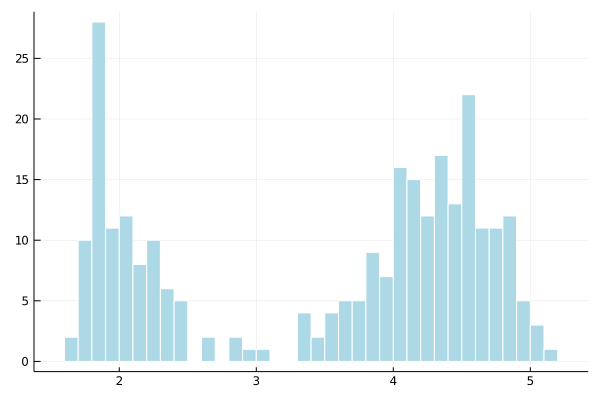

In [2]:
url = "http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat"
file = CSV.File(HTTP.get(url).body, delim = ' ', ignorerepeated = true, datarow = 27, header = 26, silencewarnings = true)

eruptions, waiting_time = Real[], Real[]

for (e, w) in file
    push!(eruptions, e)
    push!(waiting_time, w)
end

histogram(waiting_time, bins = 50, legend = false, linecolor = :white, c = :lightblue)

In [3]:
iqr(x) = quantile(x, 0.75) - quantile(x, 0.25)

# Silverman's rule of thumb bandwidth selection
bandwidth_silverman(x) = 1.06 * std(x) * length(x)^(-1/5)

# The default bandwidth selection in R's density function (bw.nrd0)
function bandwidth_nrd0(x)
    n = length(x)
    A = min(std(x), iqr(x) / 1.34)
    return 0.9 * A * n^(-1/5)
end

bandwidth_nrd0 (generic function with 1 method)

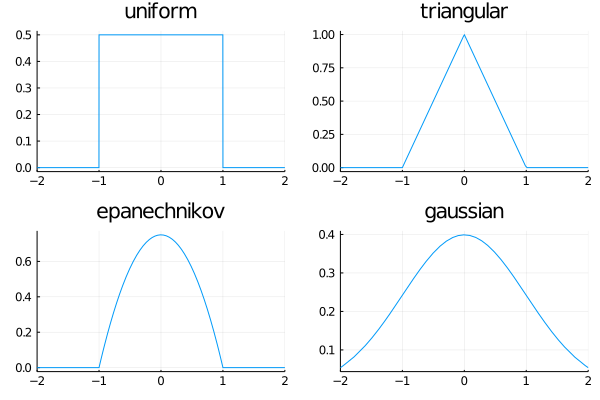

In [4]:
bounded(x, f) = -1 <= x <= 1 ? f(x) : 0

uniform(x) = bounded(x, x -> 1/2)
triangular(x) = bounded(x, x -> 1 - abs(x))
epanechnikov(x) = bounded(x, x -> 3/4 * (1 - x^2))
gaussian(x) = pdf(Normal(), x)

plots = []
for kernel in [uniform, triangular, epanechnikov, gaussian]
    push!(plots, plot(kernel, xlim = (-2, 2), title = repr(kernel)))
end
plot(plots..., legend = false)

In [5]:
struct KernelDensity
    points::Vector{Real} 
    bandwidth::Real
    kernel::Function
end

function predict(KDE::KernelDensity, x::Real)
    dens = 0
    for xi in KDE.points
        d = (x - xi) / KDE.bandwidth
        dens += KDE.kernel(d)
    end
    return dens / (KDE.bandwidth * length(KDE.points))
end

function predict(KDE::KernelDensity, x::Vector{Real})
    return [predict(KDE, xi) for xi in x]
end

predict (generic function with 2 methods)

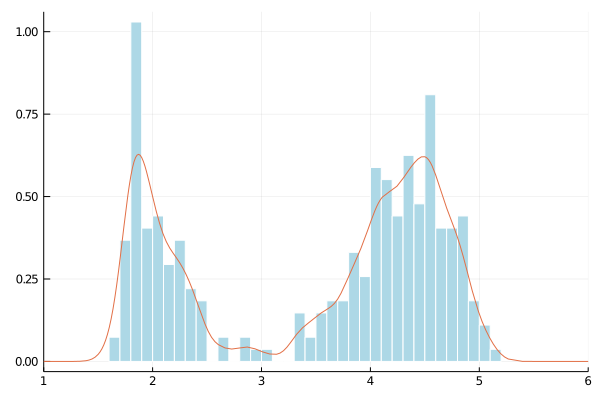

In [6]:
kde = KernelDensity(waiting_time, 0.1, gaussian)

histogram(waiting_time, bins = 50, legend = false, linecolor = :white, c = :lightblue, normalize = true)
plot!(x -> predict(kde, x), xlim = (1, 6))

In [7]:
nbins_sturges(x) = ceil(log2(length(x)) + 1)

function nbins_scott(x)
    h = 3.5 * sqrt(var(x)) * length(x)^(-1/3)
    return h > 0 ? max(1, ceil((maximum(x) - minimum(x))/h)) : 1
end

nbins_scott (generic function with 1 method)

In [8]:
mutable struct Histogram
    mids::Vector{Real}
    weights::Vector{Real}
end

function simplebin(x, breaks)
    lo, hi = minimum(x), maximum(x)
    width = (hi - lo) / breaks
    margin = width / 2
    bins = Histogram([], [])
    
    for mid in lo:width:hi
        push!(bins.mids, mid)
        n = sum((mid - margin) .<= x .< (mid + margin))
        push!(bins.weights, n)
    end
    return bins
end

simplebin (generic function with 1 method)

KDE can be used [with binned data](https://stats.stackexchange.com/questions/300746/how-to-learn-a-continous-distribution-incrementally/300773#300773).

In [9]:
struct KernelDensityBinned
    points::Vector{Real}
    weights::Vector{Real}
    bandwidth::Real
    kernel::Function
end

KernelDensityBinned(hist::Histogram, bandwidth, kernel) = KernelDensityBinned(hist.mids, hist.weights, bandwidth, kernel)

function predict(KDE::KernelDensityBinned, x::Real)
    dens = 0
    for (xi, ni) in zip(KDE.points, KDE.weights)
        d = (x - xi) / KDE.bandwidth
        dens += KDE.kernel(d) * ni 
    end
    
    N = sum(KDE.weights)
    return dens / (N * KDE.bandwidth)
end

function predict(KDE::KernelDensityBinned, x::Vector{Real})
    return [predict(KDE, xi) for xi in x]
end

predict (generic function with 4 methods)

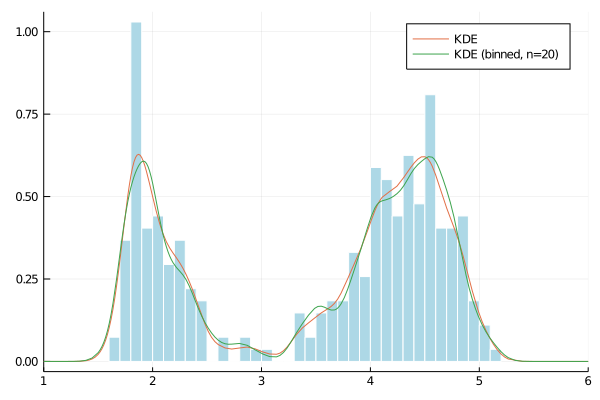

In [10]:
breaks = 20
binned = simplebin(waiting_time, breaks)
kdeb = KernelDensityBinned(binned, 0.1, gaussian)

histogram(waiting_time, bins = 50, linecolor = :white, c = :lightblue, normalize = true, label = false)
plot!(x -> predict(kde, x), xlim = (1, 6), label = "KDE")
plot!(x -> predict(kdeb, x), xlim = (1, 6), label = "KDE (binned, n=$breaks)")

We can use [online k-means algorithm](https://stackoverflow.com/questions/3698532/online-k-means-clustering) to [update the KDE bins with new data](https://stats.stackexchange.com/questions/473000/online-density-estimation-and-learning/473023#473023), by incrementing the counts and shifting the bin centeres.

In [11]:
function update!(KDE::KernelDensityBinned, x::Real)
    i = argmin(abs.(KDE.points .- x))
    KDE.weights[i] += 1
    KDE.points[i] = KDE.points[i] + (x - KDE.points[i]) / KDE.weights[i]
    return nothing
end

function update!(KDE::KernelDensityBinned, x::Vector{Real})
    for xi in x
        update!(KDE, xi)
    end
    return nothing
end

update! (generic function with 2 methods)